Example taken from https://github.com/manuel-dileo/dynamic-gnn

Notebook useful to test ROLAND in live-update setting on a snapshot-based dataset.

# IMPORT

In [1]:
!pip install torch_geometric

# Optional dependencies:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.8.0+cpu.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 84.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.1/326.1 kB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.9/222.9 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.3/198.3 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.6/241.6 kB 35.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Looking in links: https://data.pyg.org/whl/torch-2.8.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 82.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 642.7/642.7 kB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 89.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 744.3/744.3 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [2]:
!pip install networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 76.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import torch
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss, GRUCell
from torch_geometric.data import Data
from sklearn.metrics import roc_auc_score,average_precision_score

import copy


from torch_geometric.utils import negative_sampling
import torch_geometric.transforms as T
from torch_geometric.utils import train_test_split_edges
from torch_geometric.transforms import RandomLinkSplit,NormalizeFeatures, Constant
from torch_geometric.utils import from_networkx
from torch_geometric.nn import GCNConv, Linear

import torch
import networkx as nx
import numpy as np

import json

/root/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/venv/lib/python3.10/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.33' not found (required by /root/venv/lib/python3.10/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/root/venv/lib/python3.10/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.32' not found (required by /root/venv/lib/python3.10/site-packages/torch_scatter/_version_cpu.so)
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/root/venv/lib/

# Link prediction with ROLAND on BitcoinOTC

BitcoinOTC is who-trusts-whom network of people who trade using Bitcoin on a platform called Bitcoin OTC. Since Bitcoin users are anonymous, there is a need to maintain a record of users' reputation to prevent transactions with fraudulent and risky users. Members of Bitcoin OTC rate other members in a scale of -10 (total distrust) to +10 (total trust) in steps of 1. 

**Task**: predict future votes between users.

In [10]:
from torch_geometric.datasets import BitcoinOTC
data = BitcoinOTC('./bitcoinOTC')

Extracting bitcoinOTC/raw/soc-sign-bitcoinotc.csv.gz
Processing...
Done!


In [13]:
data, data[0]
#BitcoinOTC is a list of pyg Data objects, each Data object is a snapshot of the network, 
#containing the edges and the nodes of the network at a specific timestamp.

(BitcoinOTC(138), Data(edge_index=[2, 41], edge_attr=[41], num_nodes=6005))

In [16]:
import torch.nn as nn

class ROLANDGNN(torch.nn.Module):
    def __init__(self, input_dim, num_gnn_layers, hidden_dim, dropout=0.0,\
                 update='mlp', loss=BCEWithLogitsLoss,\
                 add_self_loops=False, skip_connections=False):
        
        super(ROLANDGNN, self).__init__()

        #2 MLP layers -> GNN layers stacked with embedding update -> 1 MLP layer

        self.preprocess1 = Linear(input_dim, 256)
        self.preprocess2 = Linear(256, 128)


        self.convs = nn.ModuleList()
        if skip_connections:
            hidden_dim = 128

        self.convs.append(GCNConv(128, hidden_dim))
        for _ in range(num_gnn_layers-1):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))

        self.postprocess1 = Linear(hidden_dim, 2)
        
        #Initialize the loss function to BCEWithLogitsLoss
        self.loss_fn = loss()

        self.dropout = dropout
        self.update = update
        self.num_gnn_layers = num_gnn_layers
        
        self.add_self_loops=add_self_loops
        self.skip_connections = skip_connections
        
        self.updates = nn.ModuleList()
        if update=='avg':
            self.tau0 = torch.nn.Parameter(torch.Tensor([0.2]))
        else:
            for _ in range(num_gnn_layers):
                if update=='gru':
                    self.updates.append(GRUCell(hidden_dim, hidden_dim))
                elif update=='mlp':
                    self.updates.append(Linear(hidden_dim*2, hidden_dim))
        self.previous_embeddings = None
                                    
        
    def reset_loss(self,loss=BCEWithLogitsLoss):
        self.loss_fn = loss()
        
    def reset_parameters(self):
        self.preprocess1.reset_parameters()
        self.preprocess2.reset_parameters()
        for i in range(self.num_gnn_layers):
            self.convs[i].reset_parameters()
            self.updates[i].reset_parameters()
        self.postprocess1.reset_parameters()
            
        

    def forward(self, x, edge_index, edge_label_index=None, isnap=0, previous_embeddings=None):
        
        #You do not need all the parameters to be different to None in test phase
        #You can just use the saved previous embeddings and tau
        if previous_embeddings is not None and isnap > 0: #None if test
            self.previous_embeddings = [previous_embeddings[i].clone() for i in range(self.num_gnn_layers)]
            
        current_embeddings = [torch.Tensor([]) for i in range(self.num_gnn_layers)]
        
        if self.add_self_loops:
            edge_index, _ = add_self_loops(edge_index)
            edge_index = edge_index.long()
        
        #Preprocess node repr
        h = self.preprocess1(x) 
        h = h.relu()
        h = torch.Tensor(F.dropout(h, p=self.dropout).detach().numpy())
        h = self.preprocess2(h)
        h = h.relu()
        h = torch.Tensor(F.dropout(h, p=self.dropout).detach().numpy())
        h_skip = h.clone()
        
        #ROLAND forward
        for z in range(self.num_gnn_layers):
            h = self.convs[z](h, edge_index)
            h = h.relu()
            h = torch.Tensor(F.dropout(h, p=self.dropout).detach().numpy())
            #Embedding Update after first layer
            if isnap > 0:
                #Update the embeddings
                #Best to clone and detach previous embeddings to delete the backpropagation graph history
                if self.update=='gru' or self.update=='linrnn':
                    h = torch.Tensor(self.updates[z](h, self.previous_embeddings[z].clone()).detach().numpy())
                elif self.update=='mlp':
                    hin = torch.cat((h,self.previous_embeddings[z].clone()),dim=1)
                    h = torch.Tensor(self.updates[z](hin).detach().numpy())
                else:
                    h = torch.Tensor((self.tau0 * self.previous_embeddings[z].clone() + (1-self.tau0) * h.clone()).detach().numpy())
            if self.skip_connections:
                h = torch.Tensor(torch.mul(h_skip.clone(),h.clone()))
            current_embeddings[z] = h.clone()
        
        #HADAMARD MLP to obtain link prediction scores
        h_src = h[edge_label_index[0]]
        h_dst = h[edge_label_index[1]]
        h_hadamard = torch.mul(h_src, h_dst) #hadamard product
        h = self.postprocess1(h_hadamard)
        h = torch.sum(h.clone(), dim=-1).clone()
        
        #return both 
        #i)the predictions for the current snapshot 
        #ii) the embeddings of current snapshot

        return h, current_embeddings
    
    def loss(self, pred, link_label):
        return self.loss_fn(pred, link_label)

In [19]:
from sklearn.metrics import *

def train_single_snapshot(model, isnap, data, train_data, val_data, test_data,\
                          last_embeddings, num_current_edges, num_previous_edges,\
                          optimizer, device='cpu', num_epochs=50, verbose=False):
    avgpr_val_max = 0
    best_model = model
    train_data = train_data.to(device)
    best_epoch = -1
    best_current_embeddings = []
    
    tol = 5e-04
    
    for epoch in range(num_epochs):
        model.train()
        ## Note
        ## 1. Zero grad the optimizer
        ## 2. Compute loss and backpropagate
        ## 3. Update the model parameters
        optimizer.zero_grad()
            
        #pred = best_model(train_data)

        pred,\
        current_embeddings =\
            model(train_data.x, train_data.edge_index, train_data.edge_label_index,\
                  isnap, last_embeddings)
        
        loss = model.loss(pred, train_data.edge_label.type_as(pred)) #loss to fine tune on current snapshot

        loss.backward(retain_graph=True)  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.

        ##########################################

        log = 'Epoch: {:03d}\n AVGPR Train: {:.4f}, Val: {:.4f}, Test: {:.4f}\n MRR Train: {:.4f}, Val: {:.4f}, Test: {:.4f}\n F1-Score Train: {:.4f}, Val: {:.4f}, Test: {:.4f}\n Loss: {}'
        avgpr_score_val = test(model, train_data, val_data, device)
        
        if avgpr_val_max-tol <= avgpr_score_val:
            avgpr_val_max = avgpr_score_val
            best_epoch = epoch
            best_current_embeddings = current_embeddings
            best_model = model
        else:
            break
        
        
    avgpr_score_train = test(model, train_data, train_data, device)
    avgpr_score_test = test(model, train_data, test_data, device)
    
    return best_model, optimizer, avgpr_score_train, avgpr_score_test, best_current_embeddings

In [22]:
import random

def test(model, train_data, test_data, device):
    model.eval()

    test_data = test_data.to(device)

    #IMPORTANT: x and edge_index must be from the train snapshot, only edge_label_index from test snapshot
    h, _ = model(train_data.x, train_data.edge_index, test_data.edge_label_index) 
    
    pred_cont = torch.sigmoid(h).cpu().detach().numpy()
    
    label = test_data.edge_label.cpu().detach().numpy()
      
    avgpr_score = average_precision_score(label, pred_cont)
    
    return avgpr_score

In [25]:
def train_roland(model, snapshots, hidden_dim, optimizer, device='cpu'):

    num_snap = len(snapshots)
    num_nodes = snapshots[0].num_nodes

    num_previous_edges = 0

    last_embeddings = [
        torch.zeros((num_nodes, hidden_dim)),
        torch.zeros((num_nodes, hidden_dim))
    ]

    avgpr_train_singles = []
    avgpr_test_singles = []

    for i in range(num_snap-1):
        #CREATE TRAIN + VAL + TEST SET FOR THE CURRENT SNAP
        snapshot = copy.deepcopy(snapshots[i])
        snapshot.x = torch.ones((snapshot.num_nodes, 1))
        num_current_edges = len(snapshot.edge_index[0])

        #Split the current snapshot 75/25
        transform = RandomLinkSplit(num_val=0.0,num_test=0.25)
        train_data, _, val_data = transform(snapshot)
        test_data = copy.deepcopy(snapshots[i+1])

        test_data.x = torch.ones((test_data.num_nodes, 1))
        future_neg_edge_index = negative_sampling(
            edge_index=test_data.edge_index, #positive edges
            num_nodes=test_data.num_nodes, # number of nodes
            num_neg_samples=test_data.edge_index.size(1)) # number of neg_sample equal to number of pos_edges
        
        #edge index ok, edge_label concat, edge_label_index concat
        num_pos_edge = test_data.edge_index.size(1)
        test_data.edge_label = torch.Tensor(np.array([1 for i in range(num_pos_edge)] + [0 for i in range(num_pos_edge)]))
        test_data.edge_label_index = torch.cat([test_data.edge_index, future_neg_edge_index], dim=-1)
        
        #TRAIN AND TEST THE MODEL FOR THE CURRENT SNAP
        model, optimizer, avgpr_train, avgpr_test, last_embeddings =\
            train_single_snapshot(model, i, snapshot, train_data, val_data, test_data,\
                                  last_embeddings, num_current_edges, num_previous_edges,\
                                  optimizer)
        
        #SAVE AND DISPLAY EVALUATION
        print(f'Snapshot: {i}\n AVGPR Train: {avgpr_train}, Test: {avgpr_test}\n')
        avgpr_train_singles.append(avgpr_train)
        avgpr_test_singles.append(avgpr_test)
        
        #COMPUTE NEW NUMBER OF EDGES
        num_previous_edges = num_previous_edges + num_current_edges
        
    avgpr_train_all = sum(avgpr_train_singles)/len(avgpr_train_singles)
    avgpr_test_all = sum(avgpr_test_singles)/len(avgpr_test_singles)
    
    print(f'AVGPR over time: Train {avgpr_train_all}, Test: {avgpr_test_all}')
    return avgpr_train_singles, avgpr_test_singles

In [28]:
torch.autograd.set_detect_anomaly(True)

## Train

In [31]:
input_dim = data[0].num_node_features
hidden_dim = 64

In [34]:
model = ROLANDGNN(input_dim, num_gnn_layers=2, hidden_dim=hidden_dim, update='gru')
model.reset_parameters()

In [37]:
weight_decay = 5e-3
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=weight_decay)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01, weight_decay = weight_decay)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.1, weight_decay = weight_decay)
#optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, weight_decay=weight_decay)

In [40]:
train_perf, test_perf = train_roland(model, data, hidden_dim, optimizer)

Snapshot: 0
 AVGPR Train: 0.8677419354838709, Test: 0.8095499980298413

Snapshot: 1
 AVGPR Train: 0.9243419364650186, Test: 0.8670466027669543

Snapshot: 2
 AVGPR Train: 0.8896110527582981, Test: 0.8568176268217667

Snapshot: 3
 AVGPR Train: 0.8763618775624837, Test: 0.8238065302224437

Snapshot: 4
 AVGPR Train: 0.8792976498459115, Test: 0.8734782548275969

Snapshot: 5
 AVGPR Train: 0.8621703534120542, Test: 0.8548156707679874

Snapshot: 6
 AVGPR Train: 0.8877821463000182, Test: 0.8887711088722308

Snapshot: 7
 AVGPR Train: 0.9015320886075475, Test: 0.8788164667331424

Snapshot: 8
 AVGPR Train: 0.885162616955192, Test: 0.8783977018583038

Snapshot: 9
 AVGPR Train: 0.8906716631725426, Test: 0.8923989807515286

Snapshot: 10
 AVGPR Train: 0.8818273550965555, Test: 0.8510515981476869

Snapshot: 11
 AVGPR Train: 0.9014776303776717, Test: 0.8185716357326756

Snapshot: 12
 AVGPR Train: 0.9088302235364052, Test: 0.8389335843703707

Snapshot: 13
 AVGPR Train: 0.8845885708302883, Test: 0.8431541

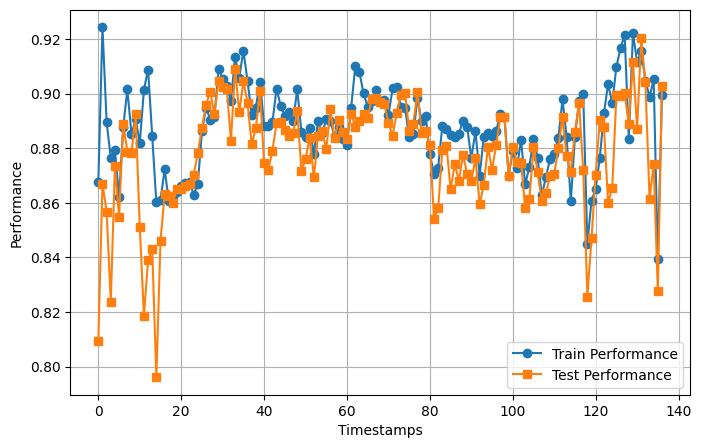

In [41]:
import matplotlib.pyplot as plt

timestamps = range(len(train_perf))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(timestamps, train_perf, marker='o', label='Train Performance')
plt.plot(timestamps, test_perf, marker='s', label='Test Performance')

plt.xlabel("Timestamps")
plt.ylabel("Performance")
plt.legend()
plt.grid(True)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=44ea447d-a946-4e9f-93c8-1e95904db5b4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>